In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2025-03-25 11:28 (eradiate v0.30.0.dev0)*

In this tutorial, we will show you how to use Eradiate to retrieve the variance of the results of your simulations. Let's start by running a simple 1D simulation and viewing its result.

In [2]:
import eradiate
import matplotlib.pyplot as plt
import numpy as np
from eradiate import scenes as ertsc
from eradiate import unit_registry as ureg

eradiate.set_mode("mono")

In [3]:
def run_exp(spp=10000, integrator=None):
    """
    Generate and run an atmosphere experiment over a hemisphere plane cut.
    """
    
    if integrator is None:
        integrator = {"type": "volpath"}
    
    exp = eradiate.experiments.AtmosphereExperiment(
        surface={
            "type":"lambertian",
            "reflectance":0.5
        },
        illumination={
            "type": "directional",
            "zenith": 30,
            "azimuth": 0,
        },
        atmosphere={
            "type": "molecular",
            "has_absorption":False
        },
        measures= {
            "type": "mdistant",
            "construct": "hplane",
            "zeniths": np.arange(-85, 86, 5),
            "azimuth": 0.0,
            "spp": spp,
            "srf": {"type": "delta", "wavelengths": 550.0 * ureg.nm},
        },
        integrator=integrator,
    )

    return eradiate.run(exp, spp=spp)

result = run_exp(spp=10000)

result

<xarray.Dataset> Size: 2kB
Dimensions:     (sza: 1, saa: 1, w: 1, y_index: 1, x_index: 35)
Coordinates:
  * sza         (sza) int64 8B 30
  * saa         (saa) int64 8B 0
  * w           (w) float64 8B 550.0
  * y_index     (y_index) int64 8B 0
    y           (y_index) float64 8B 0.0
  * x_index     (x_index) int64 280B 0 1 2 3 4 5 6 7 ... 27 28 29 30 31 32 33 34
    x           (x_index) float64 280B 0.0 0.02941 0.05882 ... 0.9412 0.9706 1.0
    vza         (x_index, y_index) int64 280B -85 -80 -75 -70 ... 70 75 80 85
    vaa         (x_index, y_index) int64 280B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Data variables:
    radiance    (w, y_index, x_index, saa, sza) float64 280B 0.273 ... 0.2833
    brdf        (w, y_index, x_index, saa, sza) float64 280B 0.1652 ... 0.1714
    brf         (w, y_index, x_index, saa, sza) float64 280B 0.519 ... 0.5386
    irradiance  (sza, saa, w) float64 8B 1.652

By default, variance is not available in the results. Variance report can be activated by setting the `moment` parameter of any integrator to `True`:

In [4]:
integrator = {"type": "piecewise_volpath", "moment": True}

We can now run the simulations again, with our new integrator.

In [5]:
var_result = run_exp(spp=10000, integrator=integrator)
var_result

<xarray.Dataset> Size: 2kB
Dimensions:       (sza: 1, saa: 1, w: 1, y_index: 1, x_index: 35)
Coordinates:
  * sza           (sza) int64 8B 30
  * saa           (saa) int64 8B 0
  * w             (w) float64 8B 550.0
  * y_index       (y_index) int64 8B 0
    y             (y_index) float64 8B 0.0
  * x_index       (x_index) int64 280B 0 1 2 3 4 5 6 7 ... 28 29 30 31 32 33 34
    x             (x_index) float64 280B 0.0 0.02941 0.05882 ... 0.9706 1.0
    vza           (x_index, y_index) int64 280B -85 -80 -75 -70 ... 70 75 80 85
    vaa           (x_index, y_index) int64 280B 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Data variables:
    radiance      (w, y_index, x_index, saa, sza) float64 280B 0.2738 ... 0.2849
    radiance_var  (w, y_index, x_index, saa, sza) float64 280B 1.706e-06 ... ...
    brdf          (w, y_index, x_index, saa, sza) float64 280B 0.1657 ... 0.1724
    brf           (w, y_index, x_index, saa, sza) float64 280B 0.5205 ... 0.5416
    irradiance    (sza, saa, w) float64 8B 1.652

Note the new `radiance_var` data variable, which is the radiance variance of our simulation. We can visualize it by plotting two standard deviations around the resulting radiance.

In [6]:
# Get the standard deviation from the variance.
std = np.sqrt(var_result.radiance_var)

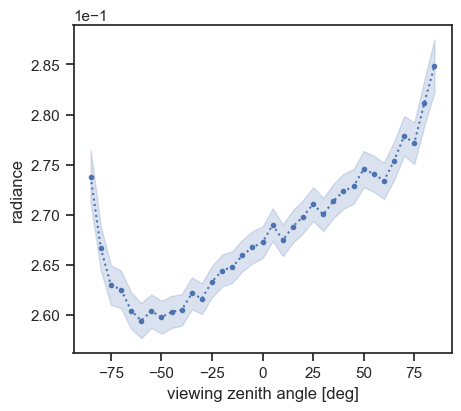

In [7]:
fig, ax = plt.subplots(1,1,figsize=(1*4.5,4), layout="constrained")

upper = (var_result.radiance + 2*std).squeeze()
lower = (var_result.radiance - 2*std).squeeze()
vza = var_result.vza.squeeze()

ax.plot(var_result.vza, var_result.radiance.squeeze().values, linestyle=":", marker=".")
ax.set_xlabel("viewing zenith angle [deg]")
ax.ticklabel_format(axis='y', scilimits=[-1,1])
ax.fill_between(vza, upper, lower, alpha=0.2, color="C0")
ax.set_ylabel("radiance")
plt.show()
plt.close()

We can repeat this process a final time with a higher sample count and see the variance go down.

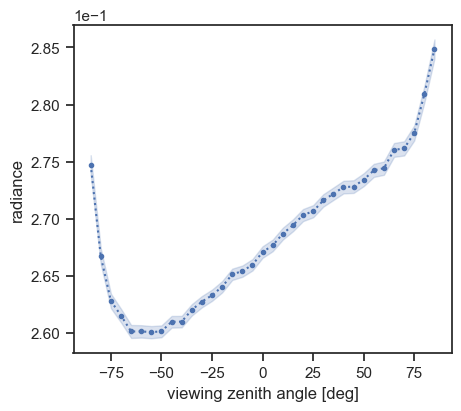

In [8]:
var_result = run_exp(spp=100000, integrator = integrator)

std = np.sqrt(var_result.radiance_var)

fig, ax = plt.subplots(1,1,figsize=(1*4.5,4), layout="constrained")

upper = (var_result.radiance + 2*std).squeeze()
lower = (var_result.radiance - 2*std).squeeze()
vza = var_result.vza.squeeze()

ax.plot(var_result.vza, var_result.radiance.squeeze().values, linestyle=":", marker=".")
ax.set_xlabel("viewing zenith angle [deg]")
ax.ticklabel_format(axis='y', scilimits=[-1,1])
ax.fill_between(vza, upper, lower, alpha=0.2, color="C0")
ax.set_ylabel("radiance")
plt.show()
plt.close()